The purpose of this notebook is to work through preprocessing steps required of all (most) data, regardless of what analyses you might be doing. That is, inputs to this notebook would be *each* subject's raw EEG data, and output is a cleaned and epoched file, ready for additional analysis.

We use ["Makato's Pipeline" as a reference](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline), as it is widely refered to. The pipeline is:

1. Change the option to use double precision
2. Import data
3. Downsample if necessary
4. High-pass filter the data at 1-Hz 
5. Import channel info
6. Remove bad channels
7. Interpolate all the removed channels
8. Re-reference the data to average 
9. Remove line noise using CleanLine 
10. Epoch data
11. Reject epochs for cleaning 
12. Adjust data rank for ICA 
13. Run ICA

Due to some differences in MNE compared to EEGLab, we re-arrange this a bit:
0. Import necessary packages
1. Read data
2. Downsample if necessary
3. High-pass filter the data at 1-Hz & reject electrical noise
4. Epoch data
5. Remove bad channels & Interpolate
6. Reject epochs 
7. Re-reference the data to average 
9. Run ICA
10. Save Data for further processing



# 1.  Import Necessary Packages

In [1]:
import os, mne
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mne import preprocessing

from autoreject import Ransac, AutoReject
from pyedfread import edf

/home/wchapman/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Additionally, many MNE plots that you may use throughout do not work using Jupyter Notebooks. We suggest either:
- Using the native interactive system via: `%matplotlib auto`
- Using the widget plugins to get interactivity back in Jupyter, via: `%matplotlib widget`

# 2. Import Data

In [2]:
mffDir = '/home/wchapman/Documents/eegProcessing/NMFLA/NMFLA2520170525.mff'
raw = mne.io.read_raw_egi(mffDir,          # mffDir = where is the data
                          preload = True,  # preload = Load data now
                         );

Reading EGI MFF Header from /home/wchapman/Documents/eegProcessing/NMFLA/NMFLA2520170525.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {STES} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
Reading 0 ... 746144  =      0.000 ...  2984.576 secs...


---
The above snipped loads the EGI data file, and generates `raw`, which is the raw traces for the continious data. Additionally, it creates "virtual" channels which are 0 or 1, for each trigger sent to the system. 

These virtual channels are useful, but we don't want to include them in many processing steps. To that end, below, we create `picks_eeg`, which is an array of channel indices which are actually EEG data.

Additionally, many EGI systems create a 129th (or, generally, n+1) channel which is the reference. We add this channel to `raw.info['bad']` so that it, also, is not involved in later analyses

In [3]:
raw.info['bads'].append('E129')
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')

# 3. Downsample if Necessary

Depending on your recording setup and whether you're interested in time-frequency analysis, you may want to downsample your data. When deciding on a downsampling, remember:

1. It's mathematically impossible to analyze frequencues more than twice your sampling rate. (Eg: If interested in Beta, which goes up to 30Hz, don't downsample to less than 60Hz)
2. Downsampling can increase your processing speed, but you can't "upsample" later to get the information back. 
3. Downsampling also reduces spurious signal (similar to low pass filtering)

In [4]:
print(raw.info['sfreq'])       # Print the original sampling rate
raw.resample(100, npad="auto") 
print(raw.info['sfreq'])       # Print the new sampling rate

250.0
1 events found
Event IDs: [1]
303 events found
Event IDs: [2]
303 events found
Event IDs: [3]
182 events found
Event IDs: [4]
182 events found
Event IDs: [5]
182 events found
Event IDs: [6]
182 events found
Event IDs: [7]
1 events found
Event IDs: [1]
303 events found
Event IDs: [2]
303 events found
Event IDs: [3]
182 events found
Event IDs: [4]
182 events found
Event IDs: [5]
182 events found
Event IDs: [6]
182 events found
Event IDs: [7]
100.0


# 4. High Pass at 1-Hz

Many analyses (eg: ICA) are sensitive to low-frequency drift, and we are typically not interested in signals in this range, so we remove this via filtering. 

First, let's look at the power spectrum for each channel, before any filtering:

---

Effective window size : 20.480 (s)


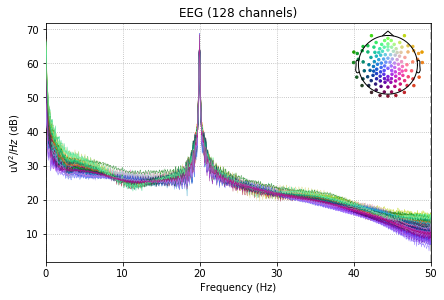

Effective window size : 20.480 (s)


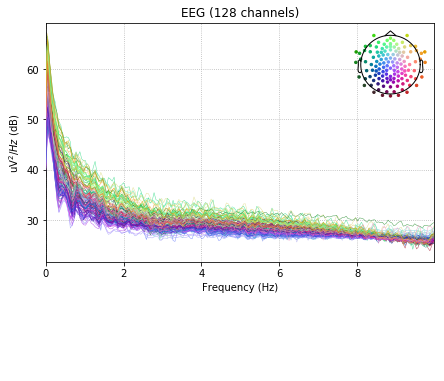

In [5]:
# Plot the entire spectrum
raw.plot_psd(area_mode='range',
             fmax=120,       # Changes how far up to plot
             average=False); # False to show all channels, true to show mean

# Zoomed in on low-frequency
raw.plot_psd(area_mode='range', 
             fmax=10,
             average=False);  

---
Note the large amount of power in the very low frequency. Next, we apply a band-pass filter to get rid of this signal. Also note that the plot WILL NOT show frequencues above the Nyquist, despite `fmax`

---

In [6]:
raw.filter(1,    # First argument is the low-pass (anything below this is filtered out)
           None, # Anything above this is filtered out (None --> allow all above the lower limit)
           fir_design='firwin');

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 331 samples (3.310 sec) selected


In [7]:
# And notch reject for electrical noise
if raw.info['sfreq'] > 120:
    raw.notch_filter(np.arange(60, raw.info['sfreq']/2, 60), 
                     filter_length='auto',
                     phase='zero')

---
Now, re-plot the power spectrum, and notice the difference.

---

Effective window size : 20.480 (s)


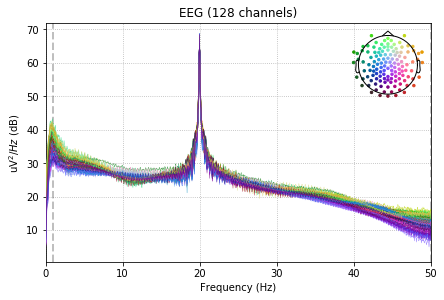

Effective window size : 20.480 (s)


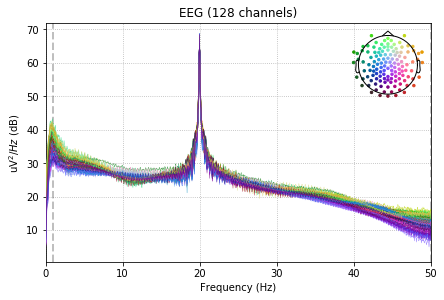

In [8]:
# Plot the entire spectrum
raw.plot_psd(area_mode='range',
             fmax=125, 
             average=False,
             picks=picks_eeg); 

# Zoomed in on low-frequency
raw.plot_psd(area_mode='range', 
             fmax=50,
             average=False,
             picks=picks_eeg);  

# 5. Epoch Data

Next, we epoch our data. Epochs are centered about some stimulus trigger, and go +/- some desired amount of time. When deciding how much time to go on each side of the stimulus, it's good to remember:

1. Each epoch should contain a `baseline` period from which we can subtract the mean signal (to account for drift). 
    - The baseline is typically some period just before the trial actually starts
2. If doing time-frequency analysis, you should have atleast 5 periods of your lowest-frequency band of interest, during the baseline. 
    - So, if you are interested in alpha, you need 500ms of baseline.
3. These epochs are used for cleaning data, and we can re-define "time zero" **within** these epochs, without going through pre-processing again. 
    - So, if you have two events of interest within a single trial (eg: stimulus onset and response), make your epochs long enough to contain both (and a baseline!). 
    
    
Here, we create an epoch based on the `SSTI` trigger, allowing a baseline of 200ms before the trigger, and going 2 seconds after is (at which point subjects timed out).

---

In [9]:
starts = mne.find_events(raw, stim_channel='SSTI')  # Find events of interest

epochs = mne.Epochs(raw,                # Raw Signal
                    starts,             # Our events
                    tmin=-0.2, tmax=2,  # 200ms before to 2 seconds after
                    baseline=(None, 0), # Use the max (200ms) to t=0 for baseline
                    picks=picks_eeg,    # Only epoch EEG channels
                    reject=None,        # See above
                    preload=True);      # Actually load the data now

182 events found
Event IDs: [4]
182 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 182 events and 221 original time points ...
0 bad epochs dropped


---
The newly created object (`epochs`) is similar to the `raw` object, except it's now shorter, and contains many repetitions. Otherwise, the two are very similar.

# 6. Remove Bad Channels

Makato has a good definition of a "bad" channel:
> "In short, the channels that you can't save even if you reject 5-10% of your datapoints"

However, learning to identify these channels can still be a time-consuing process, and leaves much to the "black arts". Relying on statistics of channels can help, but if manually rejecting, can still leave researcher degrees of freedom. Meanwhile, automated methods are becoming much more robust, allowing a fast and maximally reproducible result. 

Below we show only an automated method, based on the `RANSAC` algorithm, which identifies bad channels by identifying outliers in channel-level statistics. For information on manual rejection, see the `ManualRejection` notebook.

The method below relies on the [Autoreject](http://autoreject.github.io) package and corresponding [paper](https://arxiv.org/pdf/1612.08194.pdf)

---

In [10]:
rsc = Ransac(verbose=False)               # Create instance of the algorithm
epochs_ransac = rsc.fit_transform(epochs) # Create new epoch dataset, with 
                                          # rejected channels interpolated

Computing interpolation matrix from 122 sensor positions
Interpolating 6 sensors


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


---
The above creates a new dataset which has automatically gotten rid of problem channels and returned a cleaned dataset. One could investigate the rejected channels with `rsc.bad_chs_`. We can also see which Channel X Trial combinations were flagged as problematic:


['E3', 'E16', 'E22', 'E55', 'E126', 'E127']


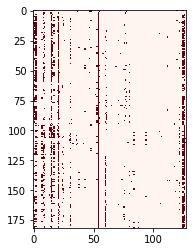

In [11]:
print(rsc.bad_chs_)

plt.imshow(rsc.bad_log, cmap='Reds',
          interpolation='nearest');

From this output, we see that the rejected sensors were bad on the majority of trials. After these are corrected for, far fewer epochs are rejected:

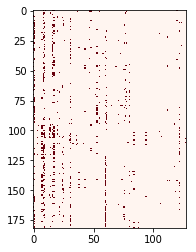

In [12]:
bad_log_rej = rsc.bad_log.copy()
bads = [i for i in range(128) if epochs.ch_names[i] in rsc.bad_chs_]
bad_log_rej[:,bads] = 0


plt.imshow(bad_log_rej, cmap='Reds',
          interpolation='nearest');

We can now see that many few Channel X Trial combinations would be marked as bad. Next, we reject individual trials which still show many issues

---

In [13]:
ar = AutoReject(verbose=False)
epochs_ransac_auto, reject_log = ar.fit_transform(epochs_ransac, return_log=True)

Computing thresholds ...
Dropped 60 epochs


And again, we can look at some information about which epochs were dropped:

In [14]:
np.argwhere(reject_log.bad_epochs).transpose()

array([[  1,   4,  22,  40,  41,  45,  49,  61,  62,  64,  70,  73,  76,
         77,  78,  79,  83,  85,  87,  89,  91,  93,  94, 102, 104, 107,
        108, 112, 117, 121, 133, 144, 147, 148, 150, 152, 153, 154, 155,
        157, 158, 159, 160, 162, 163, 164, 165, 167, 168, 169, 170, 172,
        173, 174, 175, 177, 178, 179, 180, 181]])

Finally, let's get an idea of how our evoked responses look before and after channel/trial rejection:

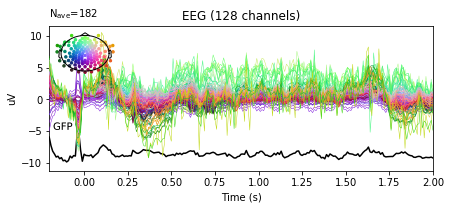

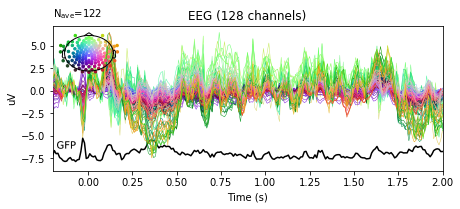

In [15]:
evoked = epochs.average()
evoked_clean = epochs_ransac_auto.average()

evoked.plot(spatial_colors=True, gfp=True, time_unit='s');
evoked_clean.plot(spatial_colors=True, gfp=True, time_unit='s');

---
In the two plots just above, we see that the individual channels appear more clean (due to dropping the spurious channels and trials), and that the GFP is less erratic. At this point, we could also investigate the remaining data and manually reject additional channels or trials (see `ManualRejection`). However, in many cases, this is sufficient as a first pass. We use `epochs_ransac_auto` for the rest of this tutorial

# 8. Re-reference data to the average

After subtracting some components and filtering our data, the grandmean of data may no longer be 0 (it was gauranteed to be upon initial import, due to using the grandmean as the reference). The simple code below brings the grandmean back to zero

In [16]:
epochs_ransac_auto, _ = mne.set_eeg_reference(epochs_ransac_auto, 'average')

Applying average reference.
Applying a custom EEG reference.


# 9. Run ICA

For manual rejection, see this helpful training website https://labeling.ucsd.edu/auth/login

For automated flagging of components, see `Components.ipynb`

---
First, we compute all components

In [17]:
ica = mne.preprocessing.ICA(n_components=20, 
          method='extended-infomax',
          random_state = 0)         # For reproducability
ica.fit(epochs_ransac_auto)

Fitting ICA to data using 128 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 6.4s.


<ICA  |  epochs decomposition, fit (extended-infomax): 26962 samples, 20 components, channels used: "eeg">

---
Then visually inspect them

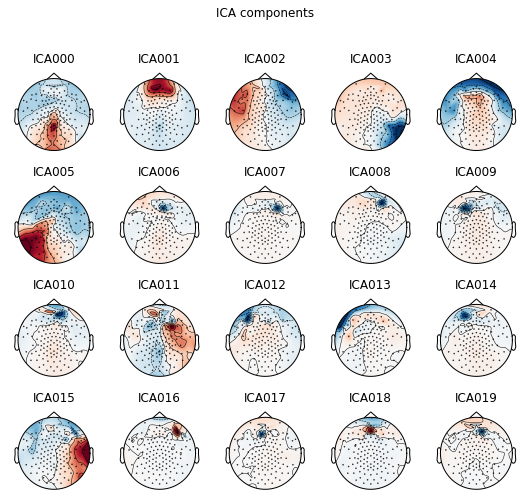

In [18]:
# overview of all topologies
ica.plot_components();

    using multitaper spectrum estimation with 7 DPSS windows


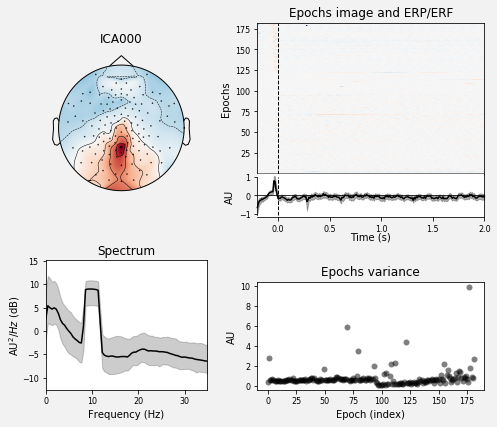

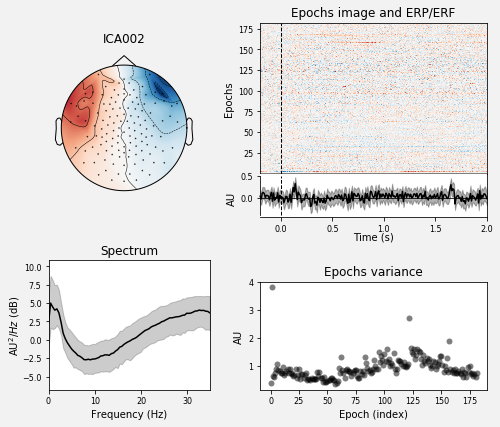

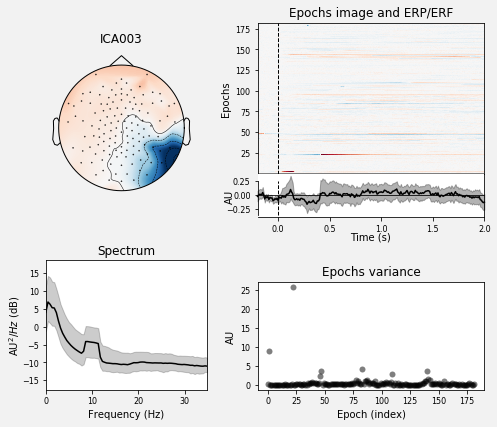

In [19]:
ica.plot_properties(epochs,picks=[0,2,3], 
                    psd_args={'fmax': 35.});
# in depth view of a subset of components

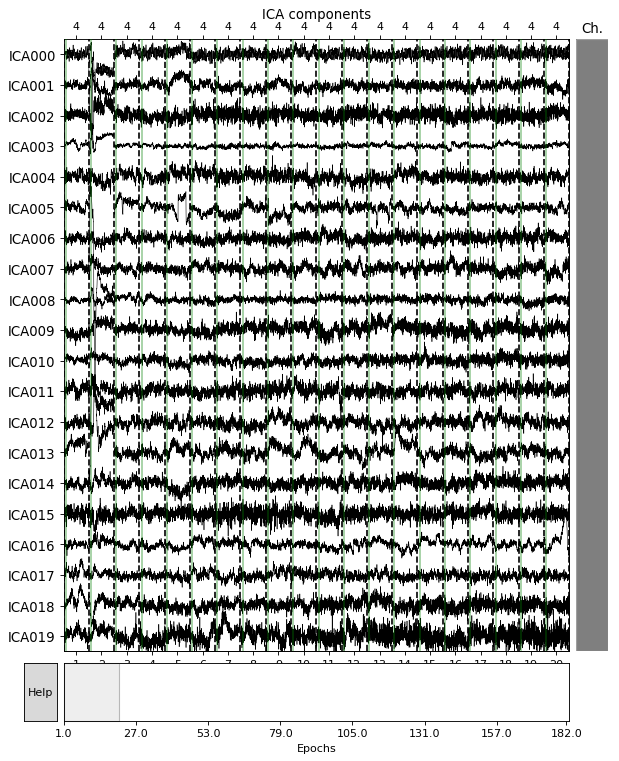

In [20]:
# Interactive view of all components over time
# Can manually reject by clicking on the name of a component
ica.plot_sources(epochs);

---

Once you've decided on which components to reject, we filter them out shown, and reconstruct the raw signal

Transforming to ICA space (20 components)
Zeroing out 2 ICA components


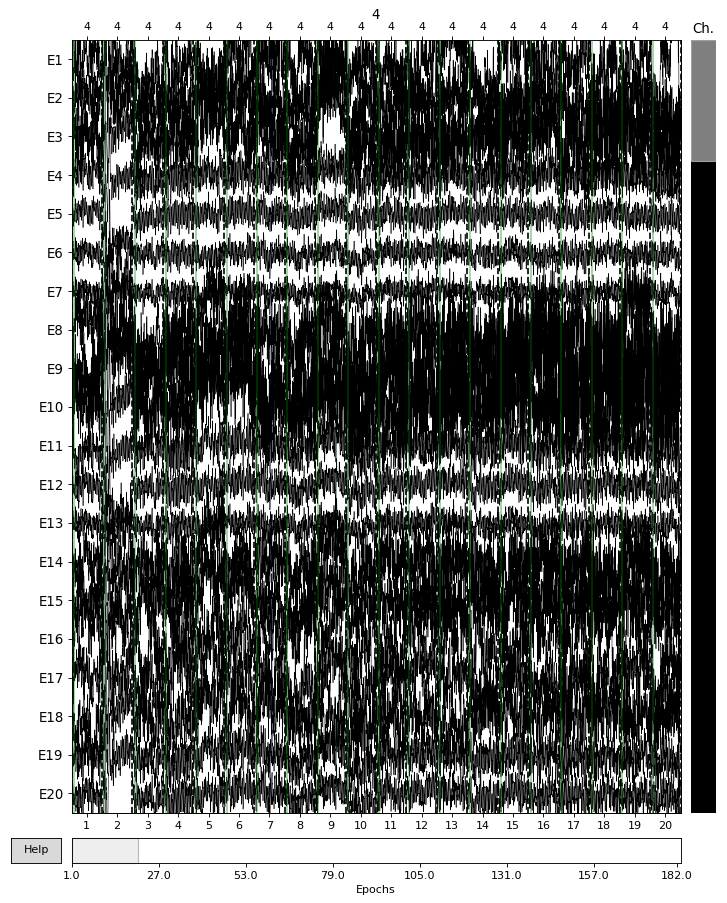

In [21]:
ica.exclude.extend([7,18]);     # List which components to reject
ep_rejected = epochs.copy();    # Create a deep copy of the data
ep_rejected.load_data();        # Load data for the deep copy
ica.apply(ep_rejected);         # Actually subtract the components
ep_rejected.plot();             # check the result

# 10. Save Epoched and Cleaned Data

In [22]:
outputFile = mffDir[0:-4] + '_epo.fif'
ep_rejected.save(fname=outputFile)